## First look at UGC993

Finding emission lines and calculating redshift

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import specutils
import astropy.units as u

from astropy.io import fits

from specutils import Spectrum1D, SpectralRegion
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from astropy.nddata import StdDevUncertainty
from specutils.fitting import find_lines_threshold

from astropy.modeling import models

In [2]:
ugc993 = fits.open('UGC993.fits')

In [3]:
header = ugc993[1].header
header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  322 / length of data axis 1                          
NAXIS2  =                  323 / length of data axis 2                          
NAXIS3  =                 3801 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [4]:
wavelength = np.arange(header['CRVAL3'], header['CRVAL3'] + header['CD3_3'] * header['NAXIS3'], header['CD3_3'])

fluxCube = ugc993[1].data
errorCube = ugc993[2].data

In [5]:
whiteImage = np.nansum(fluxCube, axis=0)

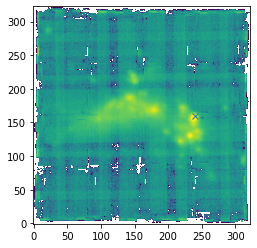

In [6]:
plt.imshow(whiteImage, origin='lower', norm=mpl.colors.LogNorm(vmin=100, vmax=1e5));

plt.plot(240, 160, 'x')

# plt.ylim(100, 200)
# plt.xlim(100, 200);

Text(0.5, 1.0, 'Noise over 10 pixels')

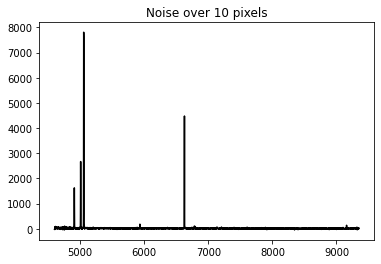

In [7]:
plt.plot(wavelength, fluxCube[:, 160, 240], 'k-');
#plt.xlim(6521.03515625, 6533.53515625)
plt.title('Noise over 10 pixels')


#print(np.mean(fluxCube[1417:1427, 160, 240]))


#### From SDSS:

H Beta - 4862.68

O III - 4960.295

O III - 5008.240

H alpha - 6564.61

In [30]:
#Wavelengths = [H beta, O III, O III, H alpha]
labs = np.array([4862.68, 4960.295, 5008.240, 6564.61])


In [31]:
def redshift(lab, observed):
    '''
    Function to calculate redshift
    '''
    return (observed - lab)/lab

(6600.0, 6700.0)

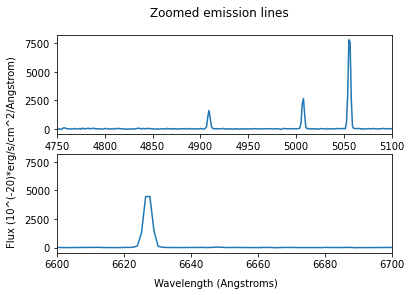

In [35]:
fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle('Zoomed emission lines')

fig.text(0.35, 0.01, 'Wavelength (Angstroms)')
fig.text(0.01, 0.15, 'Flux (10^(-20)*erg/s/cm^2/Angstrom)', rotation='vertical')

ax1.plot(wavelength, fluxCube[:, 160, 240])
ax1.set_xlim(4750, 5100)
ax2.plot(wavelength, fluxCube[:, 160, 240])
ax2.set_xlim(6600, 6700)

# Specutils

Need to redefine the spectra in terms of specutils/astropy quantities

In [36]:
lamb = wavelength * u.AA 
flux = fluxCube[:, 160, 240]* 10**-20 * u.Unit('erg cm-2 s-1 AA-1')

spec = Spectrum1D(spectral_axis = lamb, flux=flux, 
                  uncertainty = StdDevUncertainty(np.sqrt(errorCube[:, 160, 240])* 10**-20))

print(spec.shape)

(3801,)


(6000.0, 7000.0)

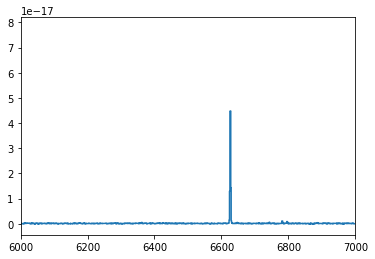

In [84]:
f, ax = plt.subplots()  

ax.step(spec.spectral_axis, spec.flux) 

ax.set_xlim(6000, 7000)

# Searching for lines with specutils

In [38]:
lines = find_lines_threshold(spec, noise_factor= 20)  
#lines = find_lines_threshold(spec, flux_threshold=0.25)

#lines[lines['line_type'] == 'emission']  

lines


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4909.02001953125,emission,247
5007.77001953125,emission,326
5055.27001953125,emission,364
6627.77001953125,emission,1622


In [39]:
spec_obs = lines['line_center']#[0]

spec_redshift = redshift(labs*u.AA, spec_obs)

print(spec_redshift)
print(f'Mean calculated redshift: {np.mean(spec_redshift)}')


[0.00952973 0.00957101 0.00939053 0.00962129]
Mean calculated redshift: 0.00952813860282882


In [48]:
print(wavelength[1622])

6627.77001953125


###### Find and subtract noise 

no lines between 10 angstrom range:

indices 1400, 1470

wavelength 6350 6440


In [51]:
halphaNoise = (fluxCube[1400:1410])


(323, 322)


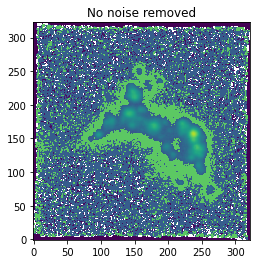

In [57]:
halphaImage = np.nansum(fluxCube[1617:1627], axis=0)
print(halphaImage.shape)

plt.imshow(halphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e5));
plt.title('No noise removed')
plt.contourf(halphaImage, levels=[1, 5, 10, 50, 100])



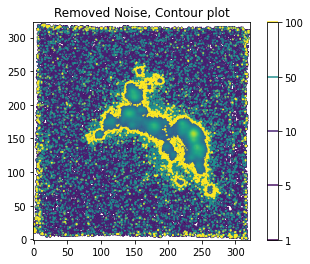

In [56]:
#Removing background noise from spectrum

HalphaImage = np.nansum((fluxCube[1617:1627] - halphaNoise), axis=0)

plt.title('Removed Noise, Contour plot')
plt.imshow(HalphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e5));

plt.contour(HalphaImage, levels=[1, 5, 10, 50, 100])
plt.colorbar()

#### Masked cubes

In [61]:
Flux250 = fluxCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Flux100 = fluxCube[:, np.array(np.where(HalphaImage >= 100))[0], np.array(np.where(HalphaImage >= 100))[1]]
Flux50 = fluxCube[:, np.array(np.where(HalphaImage >=50))[0], np.array(np.where(HalphaImage >=50))[1]]
Flux10 = fluxCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

In [69]:
(np.where(HalphaImage >= 100))[1][7134]

209

In [64]:
print(Flux250.shape)
print(Flux100.shape)
print(Flux50.shape)
print(Flux10.shape)

(3801, 5058)
(3801, 10703)
(3801, 21486)
(3801, 44647)


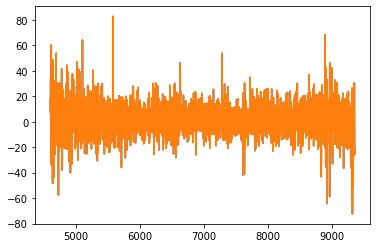

In [71]:
plt.plot(wavelength, fluxCube[:, (np.where(HalphaImage >= 100))[0][7134], (np.where(HalphaImage >= 100))[1][7134]])
plt.plot(wavelength, Flux100[:, 7134])

In [73]:
Error250 = errorCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Error100 = errorCube[:, np.array(np.where(HalphaImage >= 100))[0], np.array(np.where(HalphaImage >= 100))[1]]
Error50 = errorCube[:, np.array(np.where(HalphaImage >= 50))[0], np.array(np.where(HalphaImage >= 50))[1]]
Error10 = errorCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

Can now start trying to fit for the masked values

## Question

am I fitting gaussian to the 10 pixel length?

Text(0.5, 1.0, 'H-alpha line, 10 pixels')

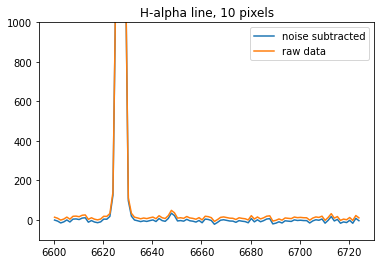

In [83]:
plt.plot(wavelength[1600:1700], fluxCube[1600:1700, 160, 240] - np.mean(halphaNoise[:, 160, 240]), label='noise subtracted')
plt.plot(wavelength[1600:1700], fluxCube[1600:1700, 160, 240], label='raw data')
#plt.xlim(6500.78515625, 6600.03515625)
plt.ylim(-100, 1000)
plt.legend()
plt.title('H-alpha line, 10 pixels')


estimate: nan
NAN
Model amplitude: 5187.973907373209


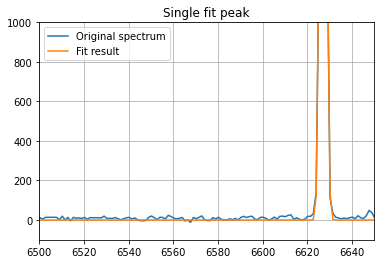

In [92]:
from astropy.modeling import models, fitting
from specutils.fitting import fit_continuum

spectrum = Spectrum1D(flux = fluxCube[1600:1700, 160, 240] * u.Unit('erg cm-2 s-1 AA-1'),
                      spectral_axis=wavelength[1600:1700]*u.AA)

sub_region = SpectralRegion(6600*u.AA, 6700*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)
#print(f'sub spectrum: {sub_spectrum}')


c_init = fit_continuum(sub_spectrum, model = models.Polynomial1D(1, c0=6.51286088, c1=0),
                       window=[(6600*u.AA, 6620*u.AA), (6660*u.AA, 6700*u.AA)])

c_model = c_init(wavelength[1622-50:1622+50]*u.AA)

sub_spectrum = extract_region(spectrum - c_model, sub_region)

estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))
print(f'estimate: {str(np.float64(estimate.stddev))}')

if str(np.float64(estimate.stddev)) == 'nan':
    print('NAN')
    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                       mean=np.float64(estimate.mean), stddev=1*u.AA)
else:
    print(f'standard deviation: {np.float64(estimate.stddev)}')
    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                       mean=np.float64(estimate.mean), stddev=np.float64(estimate.stddev))


g_fit = fit_lines(spectrum, g_init,
                  window=[(6620*u.AA, 6640*u.AA)])
y_fit = g_fit(wavelength*u.AA)
print(f'Model amplitude: {np.float64(g_fit.amplitude)}')

plt.plot(wavelength, fluxCube[:, 160, 240], label="Original spectrum")
plt.plot(wavelength, y_fit, label="Fit result")
plt.title('Single fit peak')
plt.xlim(6500, 6650)
plt.grid(True)

plt.ylim(-100, 1000)
plt.legend()


In [93]:
sub_region = SpectralRegion(6600*u.AA, 6700*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)

#print(estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

estimates = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

print(np.float64(estimates.amplitude))

print(estimates.amplitude)
print(estimates.mean)
print(estimates.stddev)



4477.21630859375
Parameter('amplitude', value=4477.21630859375, unit=erg / (Angstrom cm2 s))
Parameter('mean', value=6628.525147425954, unit=Angstrom)
Parameter('stddev', value=8.837738950304708, unit=Angstrom, bounds=(1.1754943508222875e-38, None))


## Function

Use contour lines H alpha to get pixels that will be used in an array

input array wavelength, flux

In function:

Plot spectrum

Find lines

Calculate redshift

Fit lines


In [150]:
def function(wavelength, fluxMask, error):
    
    #print(f'number of pixels: {len(fluxMask)}')
    length = len(fluxMask)
    # Write spectrum astropy way and plot spectrum
    #=======================================================================
    specutils.conf.do_continuum_function_check = False
    
    lamb = wavelength * u.AA 
    fluxData = fluxMask * u.Unit('erg cm^-2 s^-1 AA^-1')
    spec = Spectrum1D(spectral_axis = lamb, flux=fluxData, 
                  uncertainty = StdDevUncertainty(np.sqrt(error)* 10**-20))
    
    f, ax = plt.subplots()  

    ax.step(spec.spectral_axis, (spec.flux))
    ax.set_xlim(6500, 6700)
    
    # Find lines and calculate redshift
    #========================================================================
    lines = find_lines_threshold(spec, noise_factor = 50)  
    
    spec_obs = lines['line_center'][lines['line_type'] == 'emission']
    
    #if len(spec_obs)==4:
        #spec_redshift = redshift(labs*u.AA, spec_obs)
        #print(f'Mean calculated redshift: {np.mean(spec_redshift)}')
        
    if len(spec_obs) == 0:
        print(f'No lines found')
        
    else:
        print(f'{len(spec_obs)} lines found')
        #print(spec_obs)
        
    #print(f'flux shape: {fluxData.shape}')
    
    # Find centre pixel of H alpha line
    #=======================================================================
    centre_pixel = (np.where(fluxData == fluxData[1625:1650].max()))
    centre = int(np.float64(centre_pixel[-1]))
    
    #print(f'integer value of max peak: {centre}')
    
    
    # Model H alpha line using Gaussian 1D
    #=======================================================================
    #should spectrum be only 10 pixel range? Probably not, need to model continuum too. Say 50 each side
    spectrum = Spectrum1D(flux =
                fluxData[centre-50:centre+50],
                spectral_axis=wavelength[centre-50:centre+50]*u.AA)

    #print(f'spectrum: {spectrum}')
    sub_region = SpectralRegion(6620*u.AA, 6640*u.AA)

    sub_spectrum = extract_region(spectrum, sub_region)
    #print(f'sub spectrum: {sub_spectrum}')
    
        
    c_init = fit_continuum(spectrum, model = models.Polynomial1D(1, c0=6.51286088, c1=0),
                           window=[(6600*u.AA, 6620*u.AA), (6660*u.AA, 6700*u.AA)])
    c_model = c_init(wavelength[centre-50:centre+50]*u.AA)
    
    sub_spectrum = extract_region(spectrum - c_model, sub_region)
    
    estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))
    #print(f'estimate: {str(np.float64(estimate.stddev))}')
    print(f'estimate: {(np.float64(estimate.amplitude))}')
    
    if (np.float64(estimate.amplitude)) <= 0:
        g_init = models.Gaussian1D(amplitude = 20*u.Unit('erg cm^-2 s^-1 AA^-1'),
                                  mean=np.float64(estimate.mean), stddev=1*u.AA)
        
    elif str(np.float64(estimate.stddev)) == 'nan':
        print('NAN')
        g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                           mean=np.float64(estimate.mean), stddev=1*u.AA)
    else:
        print(f'standard deviation: {np.float64(estimate.stddev)}')
        g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                           mean=np.float64(estimate.mean), stddev=np.float64(estimate.stddev))
            
    
    g_fit = fit_lines(spectrum, g_init,
                      window=[(6620*u.AA, 6640*u.AA)])
    y_fit = g_fit(wavelength*u.AA)
    print(f'Model amplitude: {np.float64(g_fit.amplitude)}')
    # Plot the original spectrum and the fitted.
    #=======================================================================
    
    plt.plot(wavelength, fluxData, label="Original spectrum")
    #plt.plot(wavelength[centre-50:centre+50],
    #         flux[centre-50:centre+50], label='test emission line')
    plt.plot(wavelength, y_fit, label="Fit result")
    plt.title('Single fit peak')
    #plt.xlim(6500, 6650)
    #plt.ylim(0, 150)
    plt.grid(True)
    plt.legend()
    
    # Save Parameters
    #=============================================================================
    amplitude = np.float64(g_fit.amplitude)
    mean = np.float64(g_fit.mean)
    stddev = np.float64(g_fit.stddev)
    
    return amplitude, mean, stddev

    
    
    
    

(3801,)
846 lines found
estimate: 14.809110980824812
NAN
Model amplitude: -2.0316510895312794


/home/s1929920/.conda/envs/CP_env/lib/python3.7/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


(-2.0316510895312794, 6637.5569195174285, 1.1754943508222875e-38)

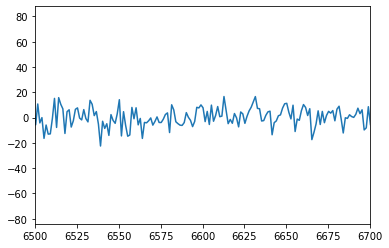

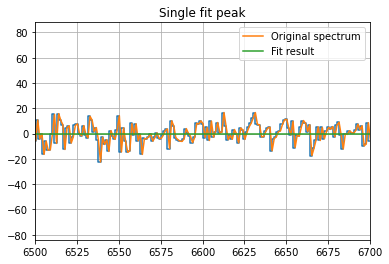

In [151]:
print(wavelength.shape)

plt.plot(wavelength, Flux100[:, 220])
plt.xlim(6500, 6700)

function(wavelength, (Flux100[:, 220]), (Error100[:, 220]))

In [ ]:
amplitudes_list = []
mean_list = []
stddev_list = []



When using specutils the wavelength must be same size or one greater than flux array?? Spectrum1D - can increase dimensions??
